In [1]:
%matplotlib inline

import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import scipy as sp
import numpy as np

plt.style.use('seaborn-whitegrid')

In [2]:
def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index()
    merged = pd.merge(
        df, source_data,
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )


**11.1. Ordered categorical outcomes**

In [3]:
data = pd.read_csv('../data/Trolley.csv', sep=';')
data.sample(5)

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
7794,ilche,7,27,97;780,32,1,Master's Degree,0,1,0,che,0
3166,flsha,5,30,96;995,23,0,Graduate Degree,0,0,0,sha,0
7664,flcar,4,15,97;767,24,0,Master's Degree,0,0,0,car,0
806,ilsha,7,21,96;560,65,0,Graduate Degree,0,1,0,sha,0
5508,ikbox,4,32,97;457,19,0,Some College,1,1,0,box,1


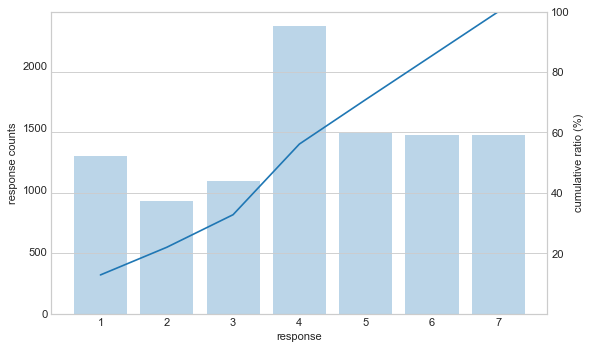

In [4]:
response_counts, responses = np.histogram(data.response, bins= np.linspace(1, 8, 8))
cum_freq = response_counts.cumsum() / response_counts.sum()

fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=80)

ax.bar(responses[:-1], response_counts, alpha=.3)
ax.set(ylabel='response counts', xlabel='response')
ax.grid(None)

ax2 = ax.twinx()
ax2.plot(responses[:-1], cum_freq * 100)
ax2.set(ylabel='cumulative ratio (%)',
        ylim=(0, 100),
        yticks=np.linspace(0, 100, 6)[1:])
None

In [18]:
with pm.Model() as m11_1:
    cutpoints = pm.Normal(
        'cutpoints', 0., 10.,
        transform=pm.distributions.transforms.ordered,
        shape=6, testval=np.arange(6) - 2.5)

    responses = pm.OrderedLogistic(
        'responses', 0., cutpoints,
        observed=data.response - 1
    )

    m11_1.name = 'm11.1'
    start = pm.find_MAP()
    m11_1.trace = pm.sample(5000, tune=1000, chains=2, start=start)


/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
  0%|          | 0/5000 [00:00<?, ?it/s]/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensi

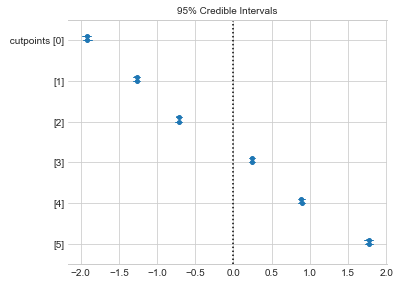

In [19]:
pm.forestplot(m11_1.trace, varnames=['cutpoints'], rhat=False)
None

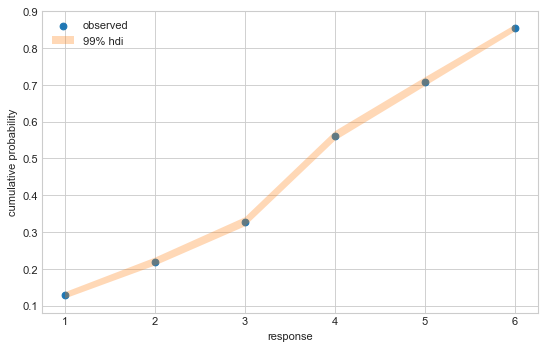

In [20]:
tmp = pd.DataFrame(m11_1.trace['cutpoints']).stack().map(sp.special.expit).reset_index()
tmp = tmp.groupby('level_1')[0].apply(summarize(0.01)).unstack()

fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=80)

ax.scatter(tmp.index + 1, cum_freq[:-1], label='observed')
ax.fill_between(tmp.index+1, tmp.lower, tmp.upper, alpha=.3, label='99% hdi')

ax.set(xlabel='response', ylabel='cumulative probability')
ax.legend()
None

In [144]:
with pm.Model() as m11_2:
    cutpoints = pm.Normal(
        'cutpoints', 0., 10.,
        transform=pm.distributions.transforms.ordered,
        shape=6, testval=np.arange(6) - 2.5)

    beta = pm.Normal('beta', mu=0, sd=2, shape=3)
    
    phi = (
        beta[0] * data.action.values
        + beta[1] * data.intention.values
        + beta[2] * data.contact.values
    )

    responses = pm.OrderedLogistic(
        'responses', phi, cutpoints,
        observed=data.response - 1
    )

    m11_2.name = 'm11.2'
    m11_2.trace = pm.sample(5000, tune=1500, chains=2)


/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, cutpoints]
Sampling 2 chains: 100%|██████████| 13000/13000 [

GridSpec(1, 1)

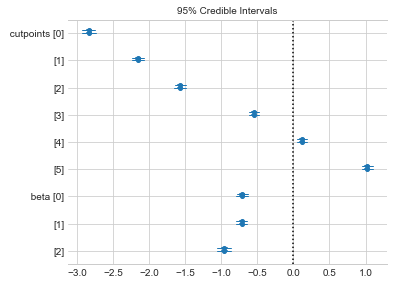

In [148]:
pm.forestplot(m11_2.trace, varnames=['cutpoints', 'beta'], rhat=False)
None

In [12]:
with pm.Model() as m11_3:
    cutpoints = pm.Normal(
        'cutpoints', 0., 10.,
        transform=pm.distributions.transforms.ordered,
        shape=6, testval=np.linspace(-2, 3, 6))

    beta = pm.Normal('beta', mu=0, sd=2, shape=(2, 2, 2))

    phi = beta[tuple([data.action.values,
                      data.intention.values,
                      data.contact.values])]

    responses = pm.OrderedLogistic(
        'responses', phi, cutpoints,
        observed=data.response - 1
    )

    m11_3.name = 'm11.3'
    start = pm.find_MAP()
    m11_3.trace = pm.sample(5000, tune=1500, chains=2, start=start)

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(s

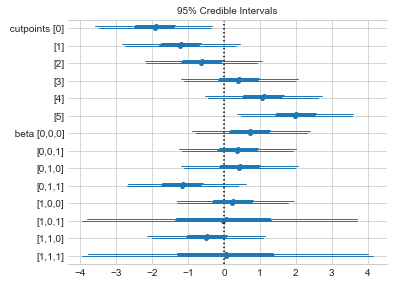

In [14]:
pm.forestplot(m11_3.trace, varnames=['cutpoints', 'beta'], rhat=False)
None

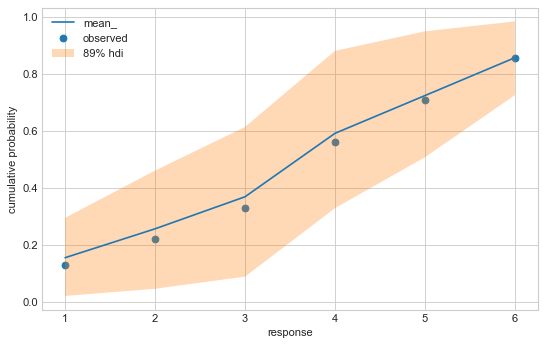

In [24]:
tmp = pd.DataFrame(m11_3.trace['cutpoints']).stack().map(sp.special.expit).reset_index()
tmp = tmp.groupby('level_1')[0].apply(summarize(0.11)).unstack()

fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=80)

ax.scatter(tmp.index + 1, cum_freq[:-1], label='observed')
ax.plot(tmp.index + 1, tmp.mean_)
ax.fill_between(tmp.index+1, tmp.lower, tmp.upper, alpha=.3, label='89% hdi')

ax.set(xlabel='response', ylabel='cumulative probability')
ax.legend()
None

In [21]:
comparison = pm.compare({
        m11_1: m11_1.trace,
        m11_3: m11_3.trace,
    },
    method='BB-pseudo-BMA'
)

comparison

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
m11.3,36929.6,11.24,0,1,79.35,0,0
m11.1,37854.4,5.97,924.8,0,57.8,62.63,0
